## Problem Statement:
- What emotion is directed towards which product

## Flow:
- Preporcess : Stopwords, Punctuation, Lemmetization.
- EDA : Word Count, Word Cloud, Max/Min/Avg Sentence and its diistrubution, target label countplot.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import spacy, re
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import tensorflow as tf
from collections import Counter, OrderedDict
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
train = pd.read_excel('assignment_dataset.xlsx', 1)
test = pd.read_excel('assignment_dataset.xlsx', 2)

In [3]:
train.head(2)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion


In [4]:
train.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5298
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [5]:
train[train['emotion_in_tweet_is_directed_at'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
...,...,...,...
8583,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product
8585,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8586,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8587,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [6]:
train['emotion_in_tweet_is_directed_at'] = train['emotion_in_tweet_is_directed_at'].fillna('other')

In [7]:
train.dropna(inplace=True)

In [8]:
train.isna().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

In [9]:
test['Tweet'].isna().sum()

0

In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
def remove_stopwords(text):
    # Remove @mentions
    text = re.sub(r'@\w+', ' ', text)
    
    # Process the text with spaCy
    doc = nlp(text.lower())
    
    # Filter tokens: remove stopwords, punctuation, and non-alphabetical tokens, and lemmatize
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    
    # Join tokens to form a clean string
    text = ' '.join(filtered_tokens)
    
    # Remove single characters and numbers
    text = re.sub(r'\b\w{1}\b|\b\d+\b', '', text)
    
    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()

    # Remove duplicates and ensure final formatting
    text = ' '.join(sorted(set(text.split())))
    
    return text

In [12]:
clean_texts = [remove_stopwords(x) for x in tqdm(train['tweet_text'].values)]

100%|█████████████████████████████████████████████████████████████████████████████| 8588/8588 [00:45<00:00, 188.90it/s]


## Preproccessing Summary:
- Removed Stopwords, metions, lemmetization, single character and number and extra white space.
- To handle Emotion column where values were NaN I have converted NaN into new label named as **"Other"**.
- To handle tweet column where value was NaN I have dropped it.

## Ways to improve data:
- As I have handled missing data, we should make sure the original data (which was given) should contain minimum missing values.
- Also the data is highly imbalance we should make sure the data is properly balanced either by reducing majority classes or oversampling or adding more data to minority class.

In [14]:
tokens = ' '.join(clean_texts).split()

In [15]:
counter = dict(sorted(Counter(tokens).items(), key=lambda item: item[1], reverse=True))

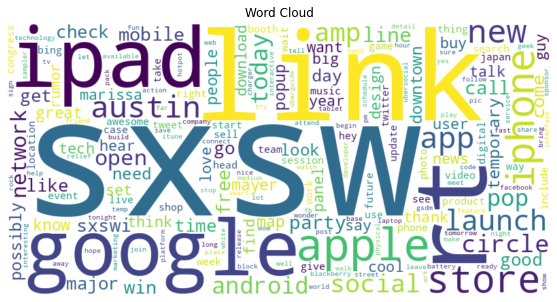

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)
plt.figure(figsize=(10, 5))
plt.title('Word Cloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

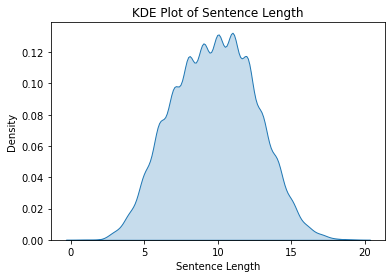

In [18]:
sb.kdeplot(list(map(lambda x:len(x.split()), clean_texts)), shade=True)
plt.title('KDE Plot of Sentence Length')
plt.xlabel('Sentence Length')
plt.ylabel('Density')
plt.show()

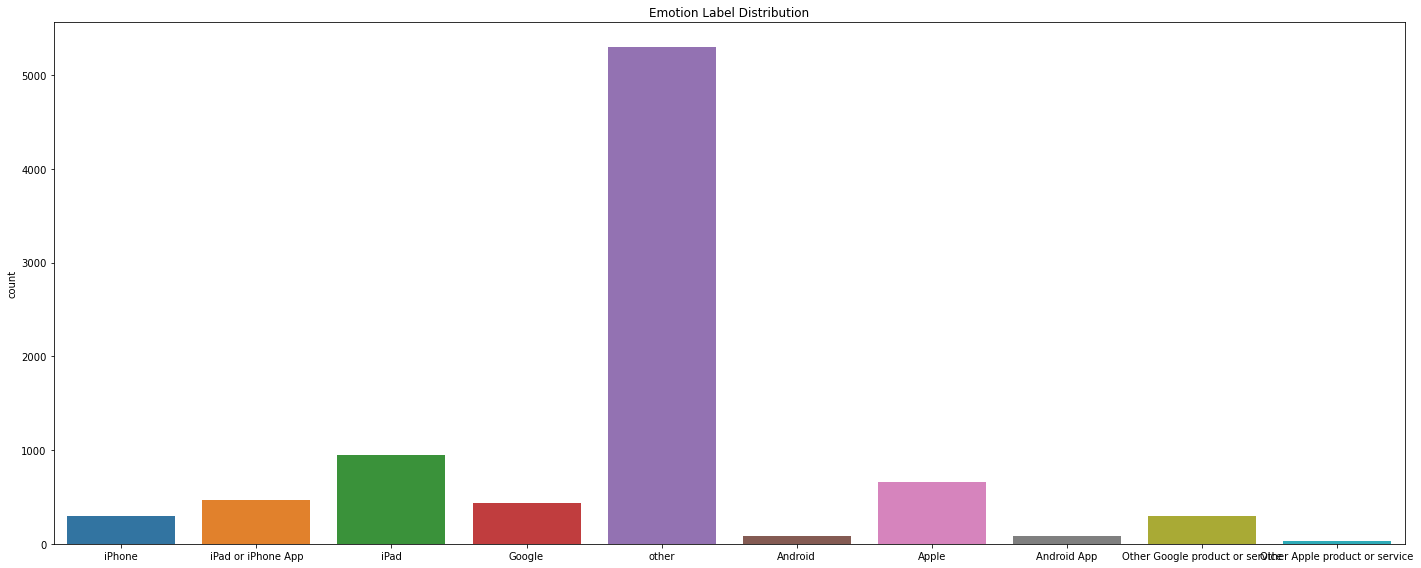

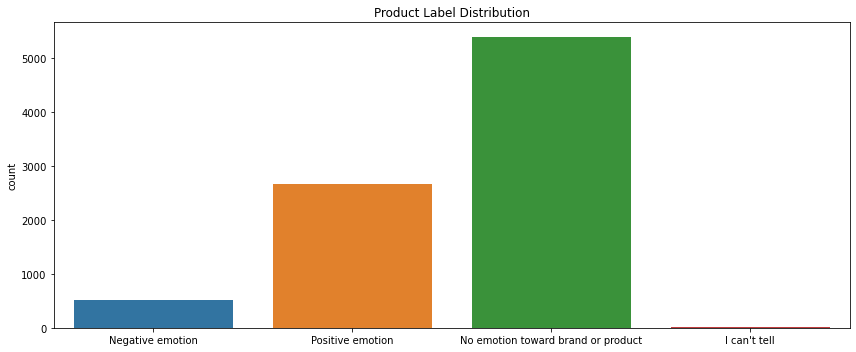

In [19]:
plt.figure(figsize=(20, 8))
plt.title('Emotion Label Distribution')
sb.countplot(train['emotion_in_tweet_is_directed_at'].values)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Product Label Distribution')
sb.countplot(train['is_there_an_emotion_directed_at_a_brand_or_product'].values)
plt.tight_layout()
plt.show()

## Analysis:
- Generally tweets follow power law distribution but this seems to be more of a gaussain.
- There labels are highly imbalanced.
- Mean is centered around 10 sentence length.
- Roughly 67% of data lies between +1 and -1 std div.

TF-IDF Matrix Shape: (8588, 7012)
Accuracy: 0.6852929763290648
Confusion Matrix:
[[   2    0    0    0    0    0    0    0    0   21]
 [   0    8    0    0    0    0    0    1    0   15]
 [   0    0   71    0    0    0    4    0    0  123]
 [   0    0    0   18    0    3    0    0    0  108]
 [   0    0    0    0    0    0    0    0    0   11]
 [   0    0    0    1    0   12    0    0    0   75]
 [   0    0    6    0    0    0  111    1    0  166]
 [   0    2    1    0    0    0    3   69    0   66]
 [   0    0    0    0    0    0    0    3   16   70]
 [   2    2   16    4    0    8   64   24   11 1459]]


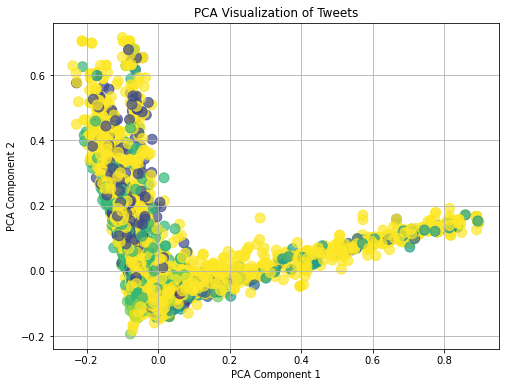

In [21]:
X = clean_texts
Y = train['emotion_in_tweet_is_directed_at'].values

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X)
print("TF-IDF Matrix Shape:", X_tfidf.shape)

lab1 = LabelEncoder()
Y = lab1.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf.toarray(), Y, test_size=0.3, random_state=42, stratify=Y)

svm = SVC(kernel='linear')  
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap='viridis', s=100, alpha=0.7)
plt.title('PCA Visualization of Tweets')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

TF-IDF Matrix Shape: (8588, 7012)
Accuracy: 0.7120682964687621
Confusion Matrix:
[[   0    0    2    0]
 [   0   22  113   21]
 [   0    9 1459  149]
 [   0    2  446  354]]


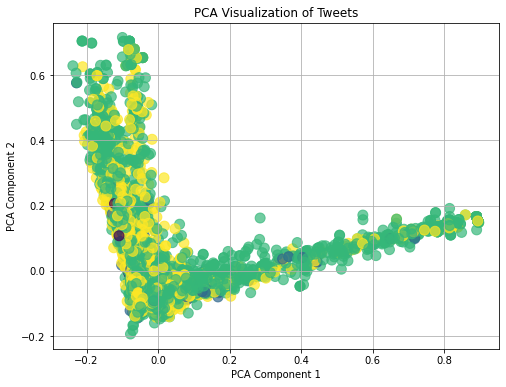

In [22]:
X = clean_texts
Y = train['is_there_an_emotion_directed_at_a_brand_or_product'].values

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X)
print("TF-IDF Matrix Shape:", X_tfidf.shape)

lab1 = LabelEncoder()
Y = lab1.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf.toarray(), Y, test_size=0.3, random_state=42, stratify=Y)

svm = SVC(kernel='linear')  
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap='viridis', s=100, alpha=0.7)
plt.title('PCA Visualization of Tweets')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

## Analysis:
- As data is not lineraly seprable using classical ML models is not suitable.

## Transformer

In [23]:
X = clean_texts.copy()
y1 = train['is_there_an_emotion_directed_at_a_brand_or_product'].values
y2 = train['emotion_in_tweet_is_directed_at'].values

In [33]:
# Combine y1 and y2
y_combined = [[label1, label2] for label1, label2 in zip(y1, y2)]

# Convert labels to strings for T5
label_strings = [' | '.join(x).lower() for x in y_combined]

In [39]:
# Create a dataset dictionary
dataset = {
    "text": X,
    "labels": label_strings
}

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    dataset["text"], dataset["labels"], test_size=0.2, random_state=42
)

# Load T5 tokenizer and model
model_name = "t5-small"  # You can change this to other T5 variants
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Tokenize the inputs
def tokenize_function(texts, labels):
    inputs = tokenizer(texts, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    targets = tokenizer(labels, padding="max_length", truncation=True, max_length=64, return_tensors="pt")
    return {
        "input_ids": inputs['input_ids'].squeeze(),
        "attention_mask": inputs['attention_mask'].squeeze(),
        "labels": targets['input_ids'].squeeze(),
    }

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

# Tokenize and create datasets
train_encodings = tokenize_function(train_texts, train_labels)
val_encodings = tokenize_function(val_texts, val_labels)

train_dataset = CustomDataset(train_encodings)
val_dataset = CustomDataset(val_encodings)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,  # Reduced batch size due to small dataset
    per_device_eval_batch_size=8,
    warmup_steps=25,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=25,
    save_steps=25,
    load_best_model_at_end=True,
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Fine-tune the model
trainer.train()

Step,Training Loss,Validation Loss
25,11.745600,6.366651
50,2.530600,1.291650
75,1.708000,0.904137
100,0.933700,0.676984
125,0.574500,0.355538
150,0.276400,0.198942
175,0.199800,0.082322
200,0.115200,0.048867
225,0.080600,0.032853
250,0.066100,0.026842


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1718, training_loss=0.3220821835699126, metrics={'train_runtime': 2061.721, 'train_samples_per_second': 6.664, 'train_steps_per_second': 0.833, 'total_flos': 1859596352225280.0, 'train_loss': 0.3220821835699126, 'epoch': 2.0})

In [44]:
# Save the fine-tuned model
model.save_pretrained("./fine_tuned_t5")
tokenizer.save_pretrained("./fine_tuned_t5")

('./fine_tuned_t5\\tokenizer_config.json',
 './fine_tuned_t5\\special_tokens_map.json',
 './fine_tuned_t5\\spiece.model',
 './fine_tuned_t5\\added_tokens.json')

In [46]:
# Load fine-tuned T5 tokenizer and model
model_name = r'./fine_tuned_t5'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to('cuda')

In [72]:
# Function to make predictions
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda')
    outputs = model.generate(**inputs)
    res = tokenizer.decode(outputs[0], skip_special_tokens=True).split(' | ')
    try:
        emotion, product = res
    except:
        emotion, product = "I can't tell", 'other'
        
    return emotion, product

In [80]:
#Test inference
example_text = 'this sony tv is very bad'
print(example_text)
emo, prod = predict(example_text)
print(f"Predicted Emotion: {emo}")
print(f"Predicted Product: {prod}")

this sony tv is very bad
Predicted Emotion: negative emotion
Predicted Product: sony tv
